In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [3]:
%matplotlib notebook

In [277]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\psth'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task']
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [282]:
#Plot the targets and obstacles: 
plot_task = True

plot_target = True
plot_obs_big = True
plot_obs_small = False
if plot_task:
    plot = {}
    plot['size'] = (10,10)
    plot['xlim'] = (-12.5,12.5)
    plot['ylim'] = (-12.5,12.5)

    plt.figure(figsize=plot['size'])

    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        for task in range(num_tasks):
            bmi_util.plot_targets(target_pos, target_color, target_r_task[task]*np.ones(num_targets))                
    plt.axis('square')
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


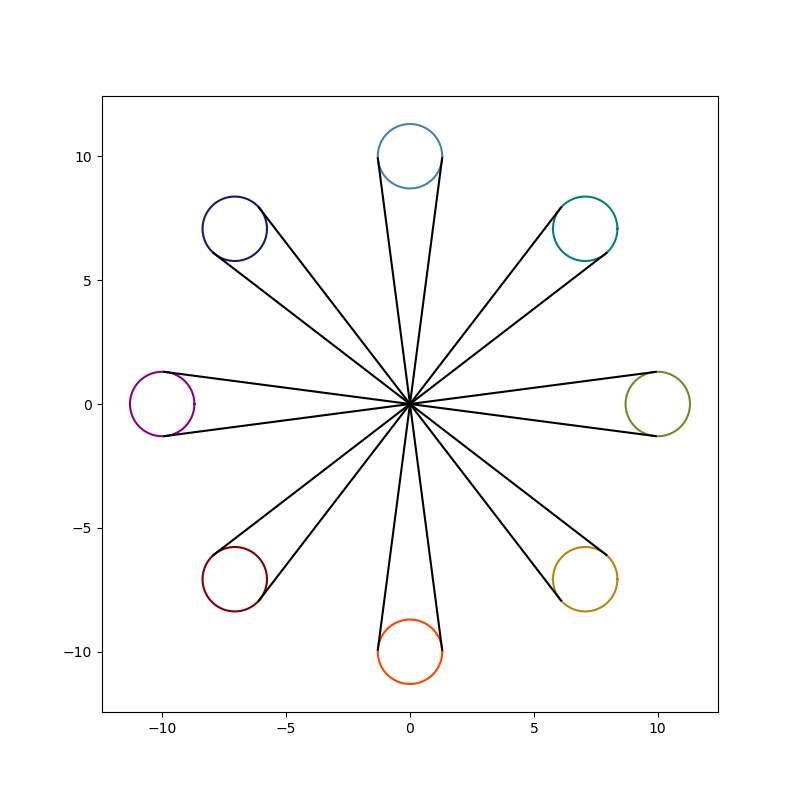

(-12.429312780353047,
 12.430327224794237,
 -12.429820002573642,
 12.429820002573642)

In [300]:
#Confirm the angles the cursor can use to hit the target
r=10

#the intersection of: x^2+(y-10)^2=4, x^2+y^2=100.  solved for using wolfram alpha.
x_sol = 13*(39831)**(0.5)/2000.0
y_sol = 19831.0/2000.0

theta_max = np.arctan2(x_sol, y_sol)
plt.figure(figsize=(8,8))
bmi_util.plot_targets(target_pos, target_color, target_r_eff[0]*np.ones(num_targets)) 
for target in range(num_targets):
    mult_list = [1,-1]
    for mult in mult_list:
        theta = target_angle[target]+theta_max*mult
        x = r*np.cos(theta)
        y = r*np.sin(theta)
        plt.plot(np.array([0, x]), np.array([0, y]), 'k')
plt.axis('square')

In [317]:
obs_x = obs_big/2.0
obs_y = 5-obs_big/2.0

obs_theta = np.arctan2(obs_x, obs_y)
print('angle to avoid obstacle:')
print(obs_theta*180/np.pi)

plt.figure()
bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
x= np.array([0, obs_x])
y=np.array([0, obs_y])
plt.plot(x,y,'k')
x= np.array([0, -obs_x])
y=np.array([0, obs_y])
plt.plot(x,y,'k')
plt.axis('square')

23.19859051364819


<IPython.core.display.Javascript object>

(-7.15, 7.15, -7.15, 7.15)

In [310]:
print(obs_x)
print(obs_y)

1.5
3.5


In [307]:
obs_big


3

In [ ]:
bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))

<IPython.core.display.Javascript object>


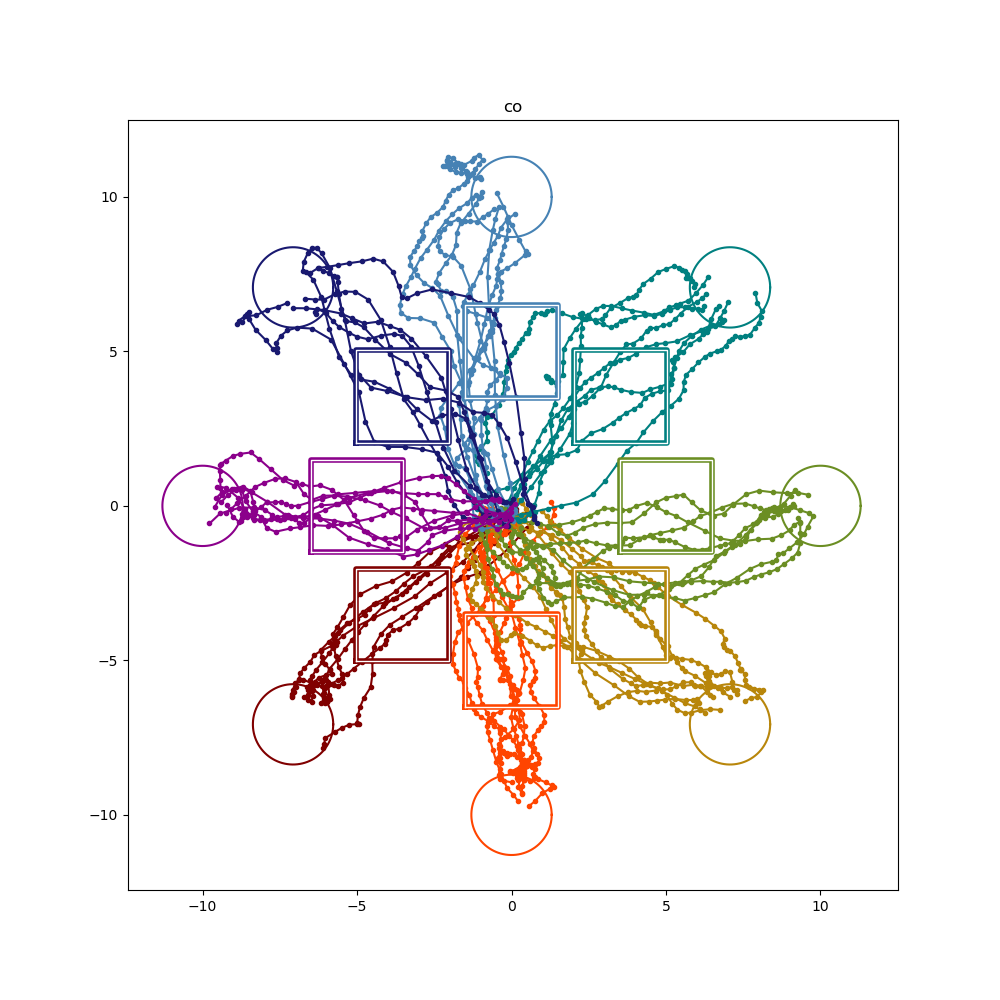

<IPython.core.display.Javascript object>


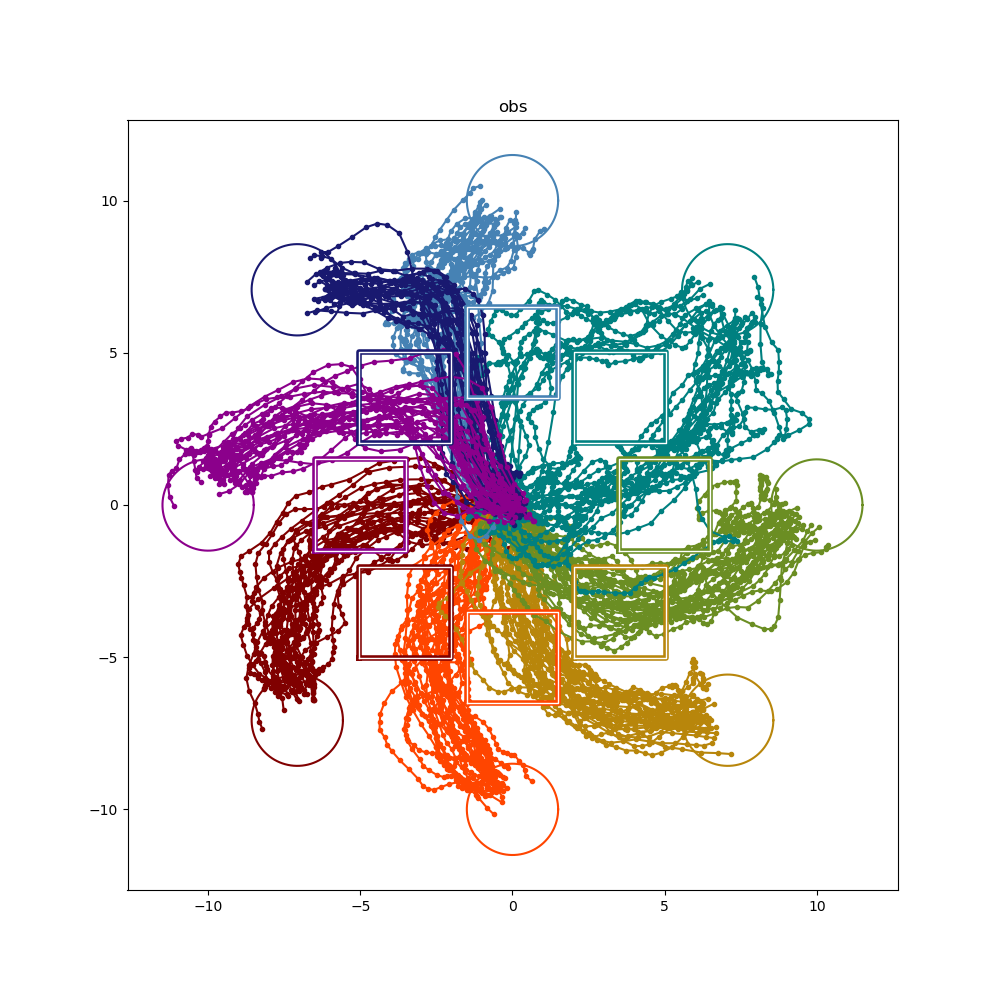

In [302]:
#PLOT INDIVIDUAL TRIALS: 
plot={}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)

for task_str in task_list:
    task = task2idx[task_str]
    plt.figure(figsize=plot['size'])
    for target in range(num_targets):
        sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target)
        df_sel = df[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.hstack((trial_start[1:]-1, len(np.where(sel)[0])))
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
#             print(x)
            color = target_color[target]
            plt.plot(x,y,'.-',color=color)

    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_eff[task]*np.ones(num_targets))  
    
    plt.axis('square')
    plt.title(task_str)
#     plt.xlim(plot['xlim'])
#     plt.ylim(plot['ylim'])
    plt.show()

In [ ]:
#Convert stuff to polar, calculate distance to target

In [31]:
df.columns

Index([u'n_0', u'n_1', u'n_2', u'n_3', u'n_4', u'n_5', u'n_6', u'n_7', u'n_8',
       u'n_9', u'n_10', u'n_11', u'n_12', u'n_13', u'n_14', u'n_15', u'n_16',
       u'n_17', u'n_18', u'n_19', u'n_20', u'n_21', u'n_22', u'n_23', u'n_24',
       u'n_25', u'n_26', u'n_27', u'n_28', u'n_29', u'n_30', u'n_31', u'n_32',
       u'n_33', u'n_34', u'n_35', u'n_36', u'n_37', u'n_38', u'n_39', u'n_40',
       u'n_41', u'n_42', u'n_43', u'u_px', u'u_py', u'u_vx', u'u_vy',
       u'kin_px', u'kin_py', u'kin_vx', u'kin_vy', u'task', u'tc', u'target',
       u'trial', u'bin', u'p_mag', u'p_angle', u'v_mag', u'v_angle',
       u'u_p_mag', u'u_p_angle', u'u_v_mag', u'u_v_angle'],
      dtype='object')

In [ ]:
#put indicators of trial_start, trial_stop

In [286]:
# 1) Convert stuff to polar, 2) center angles at target angle, 3) calculate distance to target
# 1) Convert stuff to polar
df['p_mag'], df['p_angle'] = bmi_b.cartesian2polar(df['kin_py'], df['kin_px'])
df['v_mag'], df['v_angle'] = bmi_b.cartesian2polar(df['kin_vy'], df['kin_vx'])
df['u_p_mag'], df['u_p_angle'] = bmi_b.cartesian2polar(df['u_py'], df['u_px'])
df['u_v_mag'], df['u_v_angle'] = bmi_b.cartesian2polar(df['u_vy'], df['u_vx'])
# 2) Center @ target angle: 
d_list = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in d_list:
    data = df[d]
    zeros = np.zeros(data.shape)
    t_angle = target_angle[df['target'].astype(int)]
    df[d+'_ctr'] = bmi_b.center_angle(df[d], zeros, t_angle)
# 3) distance to target
error = df.loc[:, 'kin_px':'kin_py']-target_pos[df['target'].astype(int),:]
df['d2target'] = np.linalg.norm(error,ord=2,axis=1)
df['x_error'] = error.loc[:,'kin_px']
df['y_error'] = error.loc[:,'kin_py']


In [287]:
df.loc[0:55, ['target','bin', 'trial_start', 'trial_stop', 'd2target']]

target   bin  trial_start  trial_stop   d2target
0      0.0 -10.0          0.0         0.0  18.560671
1      0.0  -9.0          0.0         0.0  18.844048
2      0.0  -8.0          0.0         0.0  19.180040
3      0.0  -7.0          0.0         0.0  19.319563
4      0.0  -6.0          0.0         0.0  19.482174
5      0.0  -5.0          0.0         0.0  19.487144
6      0.0  -4.0          0.0         0.0  19.347643
7      0.0  -3.0          0.0         0.0   9.780188
8      0.0  -2.0          0.0         0.0   9.778908
9      0.0  -1.0          0.0         0.0   9.636667
10     0.0   0.0          1.0         0.0   9.463396
11     0.0   1.0          0.0         0.0   9.331970
12     0.0   2.0          0.0         0.0   9.078341
13     0.0   3.0          0.0         0.0   8.757569
14     0.0   4.0          0.0         0.0   8.383691
15     0.0   5.0          0.0         0.0   7.936010
16     0.0   6.0          0.0         0.0   7.608077
17     0.0   7.0          0.0         0.0   7.227405
18     0.0   8.0          0.0         0.0   6.762120
19     0.0   9.0          0.0         0.0   6.327757
20     0.0  10.0          0.0         0.0   5.876916
21     0.0  11.0          0.0         0.0   5.571757
22     0.0  12.0          0.0         0.0   5.270490
23     0.0  13.0          0.0         0.0   4.973313
24     0.0  14.0          0.0         0.0   4.625216
25     0.0  15.0          0.0         0.0   4.435875
26     0.0  16.0          0.0         0.0   4.219515
27     0.0  17.0          0.0         0.0   4.066731
28     0.0  18.0          0.0         0.0   3.949040
29     0.0  19.0          0.0         0.0   3.737440
30     0.0  20.0          0.0         0.0   3.428611
31     0.0  21.0          0.0         0.0   2.990633
32     0.0  22.0          0.0         0.0   2.662363
33     0.0  23.0          0.0         0.0   2.388489
34     0.0  24.0          0.0         0.0   2.177936
35     0.0  25.0          0.0         0.0   2.044380
36     0.0  26.0          0.0         0.0   1.814991
37     0.0  27.0          0.0         0.0   1.687016
38     0.0  28.0          0.0         0.0   1.571461
39     0.0  29.0          0.0         0.0   1.426684
40     0.0  30.0          0.0         0.0   1.377756
41     0.0  31.0          0.0         0.0   1.327379
42     0.0  32.0          0.0         0.0   1.389337
43     0.0  33.0          0.0         0.0   1.436565
44     0.0  34.0          0.0         0.0   1.505731
45     0.0  35.0          0.0         0.0   1.700288
46     0.0  36.0          0.0         0.0   1.801253
47     0.0  37.0          0.0         0.0   1.718691
48     0.0  38.0          0.0         0.0   1.551812
49     0.0  39.0          0.0         0.0   1.416269
50     0.0  40.0          0.0         0.0   1.353146
51     0.0  41.0          0.0         0.0   1.328749
52     0.0  42.0          0.0         0.0   1.245103
53     0.0  43.0          0.0         0.0   1.211472
54     0.0  44.0          0.0         1.0   1.146614
55     0.0 -10.0          0.0         0.0   7.864205

In [289]:
#INTERPOLATED PSTH:
#TRIALS GO FROM START TO TIME CURSOR HITS TARGET BOUNDARY
#FORM: xarray for variable x time x trial: 

#(1.7 - 0.4 = 1.3 for CO, and 2.0 - 0.5 = 1.5 for OBS).
target_r_eff = {0:1.3, 1:1.5}
num_var = df.shape[1]
num_interp_pts = 100
time_win = np.array([0, num_interp_pts])
num_time = np.diff(time_win)[0]
da_dic = {}
for task_str in task_list:
    task = task2idx[task_str]
    for target in range(num_targets):
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------
        #Initialize a nan-filled xarray
        nan_mat = np.ones((num_var, num_time, num_trials))*np.nan
        da = xr.DataArray(nan_mat,
                    coords={'var':list(df.columns),
                                     'time':range(num_time),
                                     'trial':range(num_trials)},
                    dims=['var','time','trial'])
        for trial, bnd in enumerate(trial_bound): #trial_bound[0:1,:]:
            d2target = df.loc[bnd[0]:bnd[1],'d2target']
            end = bnd[0]+np.where(d2target <= target_r_eff[task])[0][0]
            trial_len = end-bnd[0]+1
            #Linearly interpolate the trial: 
            d_trial = np.array(df.loc[bnd[0]:end,:])
            x = np.arange(0,trial_len)
            f = scipy.interpolate.interp1d(x,d_trial,axis=0)
            x_interp = np.linspace(x[0],x[-1],num_interp_pts)
            d_interp = f(x_interp).T
            da[:,:,trial] = d_interp
        da_dic[(task,target)] = da      

In [271]:
df.loc[bnd[0]:bnd[1]+10, ['bin', 'd2target', 'task']]

bin  d2target  task
2949   2.0  9.636538   1.0
2950   3.0  9.261644   1.0
2951   4.0  9.010996   1.0
2952   5.0  8.781673   1.0
2953   6.0  8.398230   1.0
2954   7.0  7.964802   1.0
2955   8.0  7.454874   1.0
2956   9.0  7.213420   1.0
2957  10.0  6.971541   1.0
2958  11.0  6.727714   1.0
2959  12.0  6.353269   1.0
2960  13.0  5.972976   1.0
2961  14.0  5.729275   1.0
2962  15.0  5.550558   1.0
2963  16.0  5.374569   1.0
2964  17.0  5.194163   1.0
2965  18.0  4.920294   1.0
2966  19.0  4.602421   1.0
2967  20.0  4.091567   1.0
2968  21.0  3.746528   1.0
2969  22.0  3.467131   1.0
2970  23.0  3.243850   1.0
2971  24.0  3.035780   1.0
2972  25.0  2.965872   1.0
2973  26.0  2.857526   1.0
2974  27.0  2.598541   1.0
2975  28.0  2.271568   1.0
2976  29.0  2.048488   1.0
2977  30.0  1.856151   1.0
2978  31.0  1.654839   1.0
2979  32.0  1.507469   1.0
2980  33.0  1.385010   1.0
2981  34.0  1.427611   1.0
2982  35.0  1.586803   1.0
2983 -10.0  1.747620   1.0
2984  -9.0  1.754510   1.0
2985  -8.0  1.683476   1.0
2986  -7.0  1.452756   1.0
2987  -6.0  1.298629   1.0
2988  -5.0  1.178216   1.0
2989  -4.0  1.128197   1.0
2990  -3.0  1.064352   1.0
2991  -2.0  9.894645   1.0
2992  -1.0  9.867699   1.0

In [147]:
df.loc[bnd[0]:end,['bin', 'd2target']]

bin   d2target
14688   0.0  10.080451
14689   1.0   9.983095
14690   2.0   9.885458
14691   3.0   9.581753
14692   4.0   9.354770
14693   5.0   9.148338
14694   6.0   9.094624
14695   7.0   9.005907
14696   8.0   8.840917
14697   9.0   8.547607
14698  10.0   8.092805
14699  11.0   7.403301
14700  12.0   6.556246
14701  13.0   5.931617
14702  14.0   5.487364
14703  15.0   5.289633
14704  16.0   5.238427
14705  17.0   4.998831
14706  18.0   4.565045
14707  19.0   4.038332
14708  20.0   3.579212
14709  21.0   3.182619
14710  22.0   2.868115
14711  23.0   2.635286
14712  24.0   2.389702
14713  25.0   1.979173

In [290]:
#CALCULATE PSTH:
psth_dic = {}
for task in range(num_tasks):
    for target in range(num_targets):
        mean = da_dic[task,target].mean(axis=2,skipna=True)
        N = np.logical_not(np.isnan(da_dic[task,target])).sum(axis=2) #number of data points per sample
        var = da_dic[task,target].var(axis=2,skipna=True)
        sem = (var/N)**(0.5)
        
        psth_dic[task,target,'mean'] = mean
        psth_dic[task,target,'N'] = N
        psth_dic[task,target,'var'] = var
        psth_dic[task,target,'sem'] = sem

In [313]:
target_r_task

{0: 1.7, 1: 2.0}

<IPython.core.display.Javascript object>


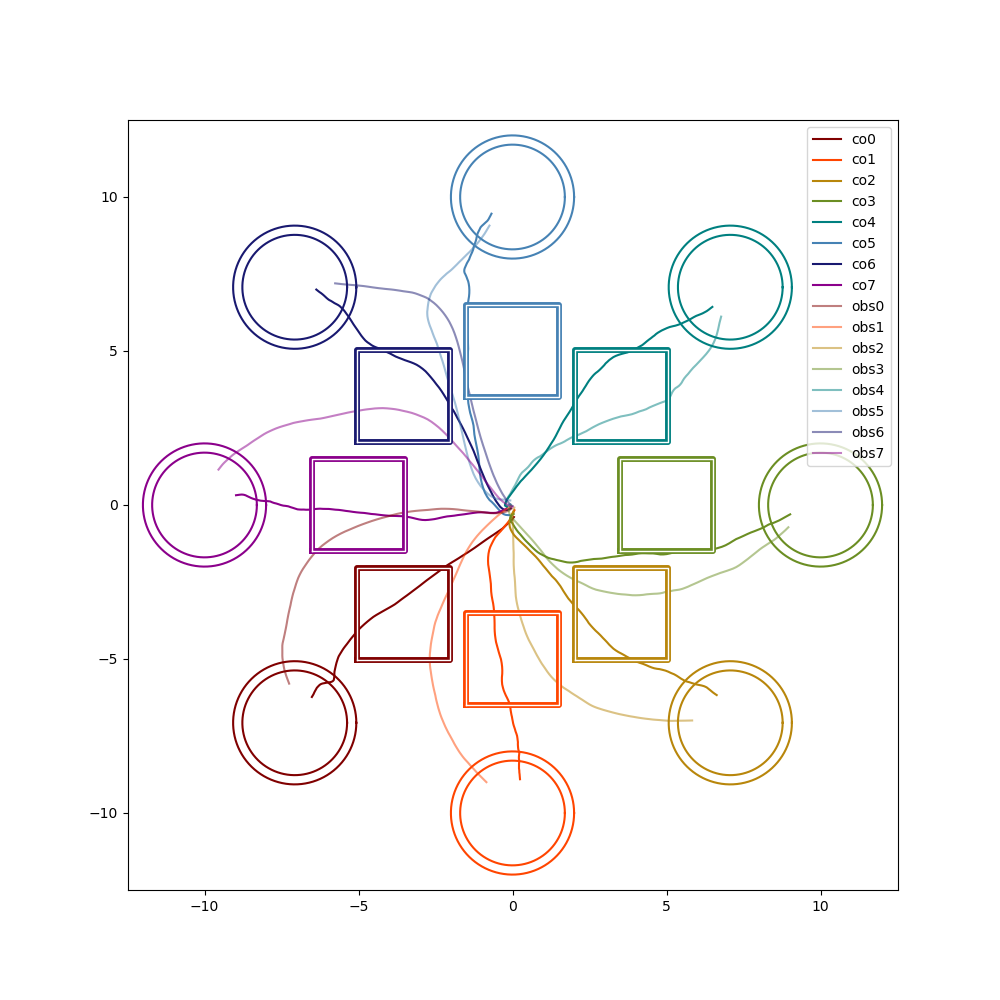

In [314]:
#PLOT PSTH
plt_prefix = 'psth_p_traj'
plt_ext = ['.png']

plt_len = 100

save_bool = False

plt.figure(figsize=plot['size'])
for task_str in task_list:
    task = task2idx[task_str]
    for target in range(num_targets):
        data = psth_dic[task,target,'mean']
        count = psth_dic[task,target,'N']
        
        x = data.loc['kin_px'][:plt_len] #num_time X num_trials
        y = data.loc['kin_py'][:plt_len]
        color = target_color[target]
        plt.plot(x, y, '-', color=color, alpha=1-task*0.5, label=task_str + str(target))
    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_task[task]*np.ones(num_targets))  
    
    plt.axis('square')
    plt.legend()
#     plt.title(task_str)
    plt.xlim(plot['xlim'])
    plt.ylim(plot['ylim'])
    plt.show()
    
    #---------------------------------------------------------------------------------------------
    if save_bool:
        plt_name = plt_prefix + '_' + idx2task[task]
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))    

<IPython.core.display.Javascript object>


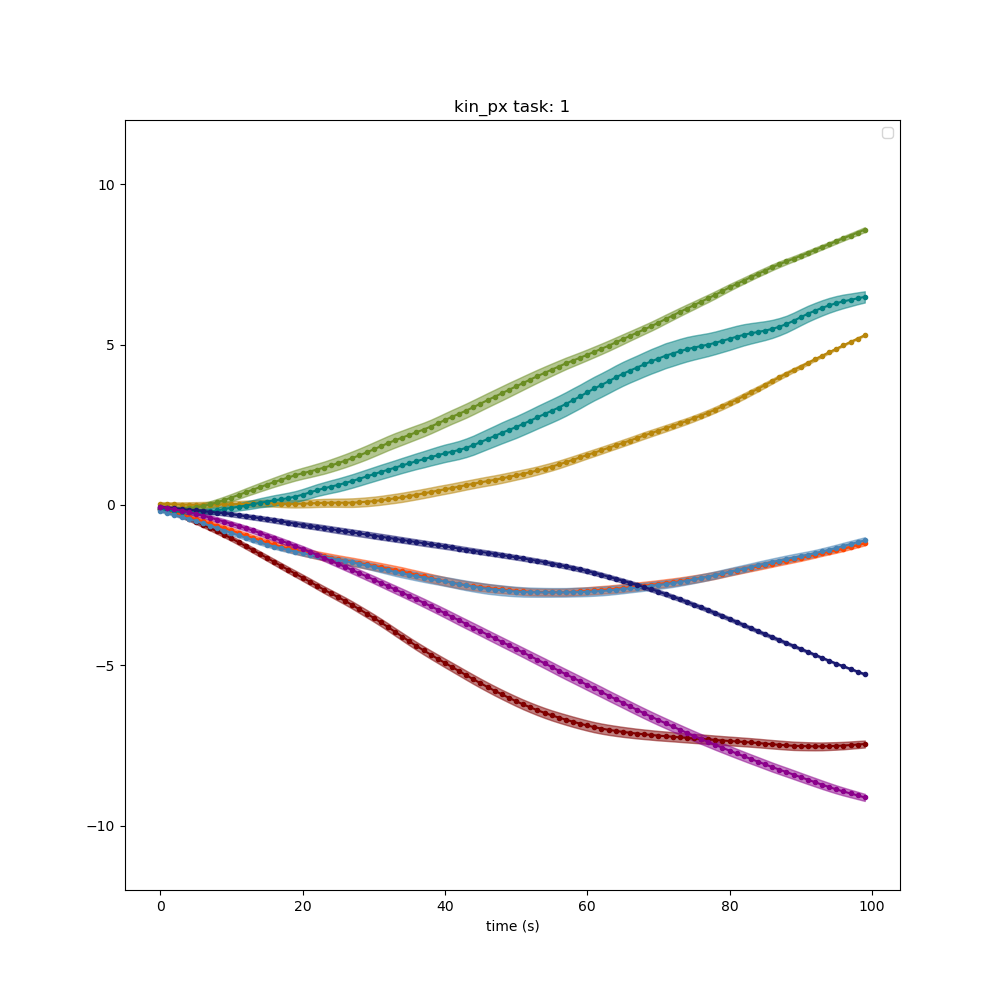

<IPython.core.display.Javascript object>

In [212]:
#Per task, all conditions together: 
plot_data = ['kin_px', 'kin_py']
for d in plot_data:
    for task in [1]:
        plt.figure(figsize=(10,10))
        for target in range(num_targets):
            t = psth_dic[task,target,'mean']['time']
            x = psth_dic[task,target,'mean'].loc[d]
            x_sem = psth_dic[task,target,'sem'].loc[d]

            #Plot: 
            plt.plot(t,x,'.-', color=target_color[target])
            plt.fill_between(t, x-x_sem,x+x_sem,alpha=0.5,color=target_color[target])
        plt.legend()
        plt.title(d + ' task: ' + str(task))
        plt.xlabel('time (s)')
#         plt.xlim([0, 8])
        plt.ylim([-12,12])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


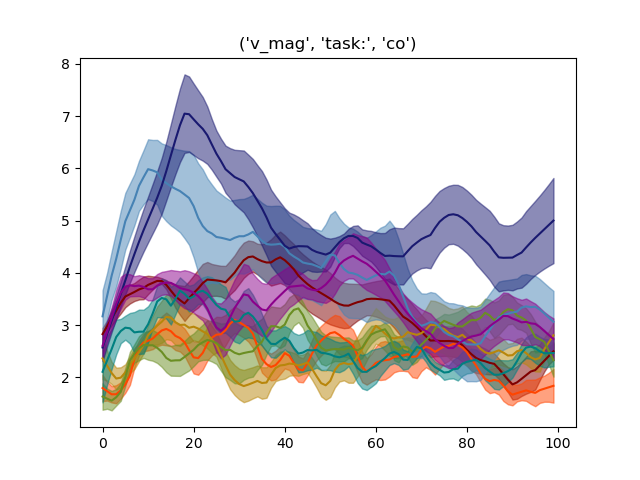

<IPython.core.display.Javascript object>


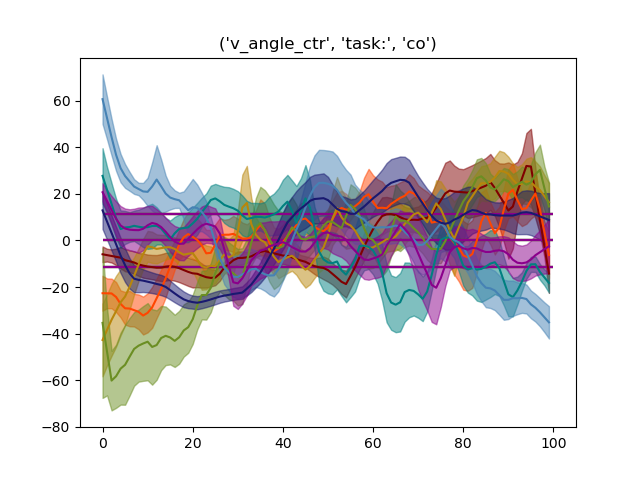

<IPython.core.display.Javascript object>


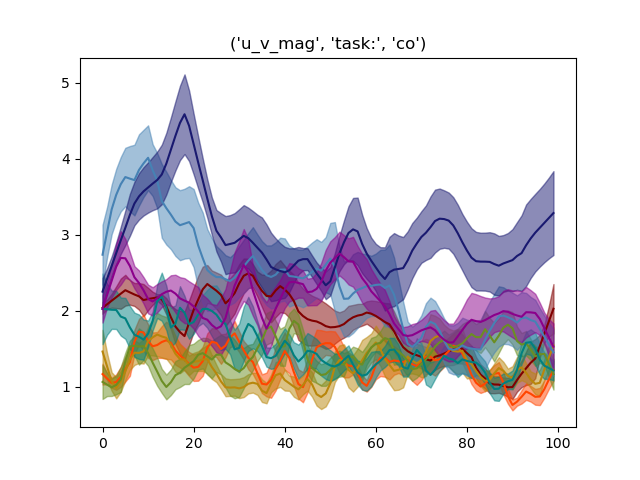

<IPython.core.display.Javascript object>


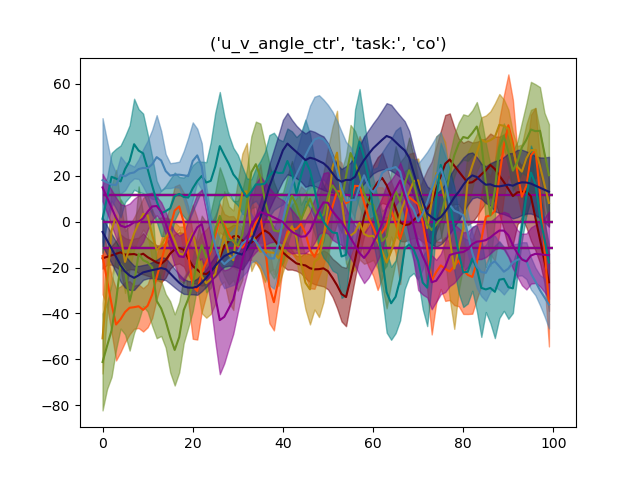

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


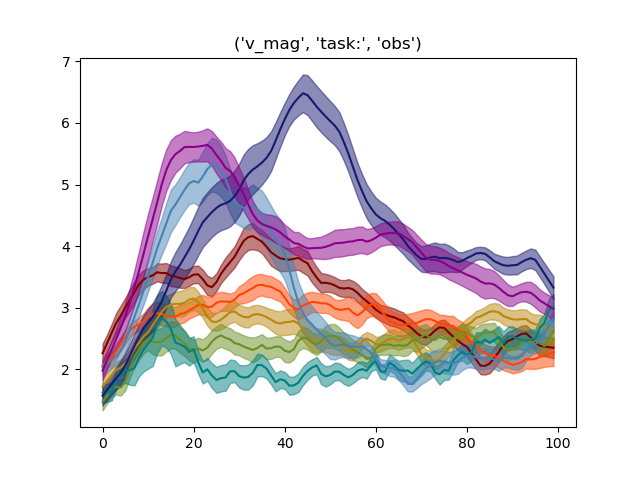

<IPython.core.display.Javascript object>


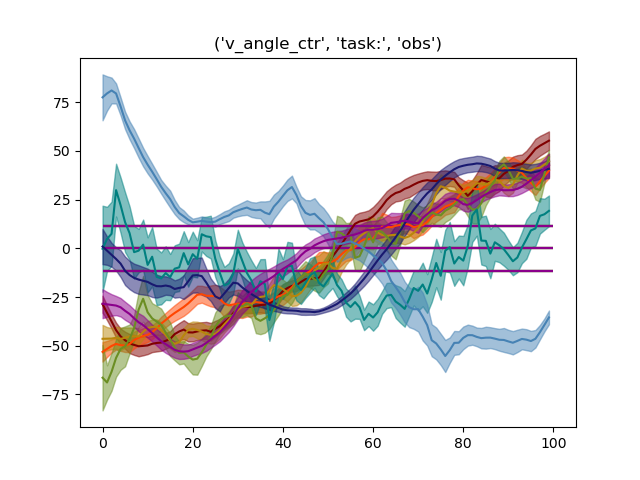

<IPython.core.display.Javascript object>


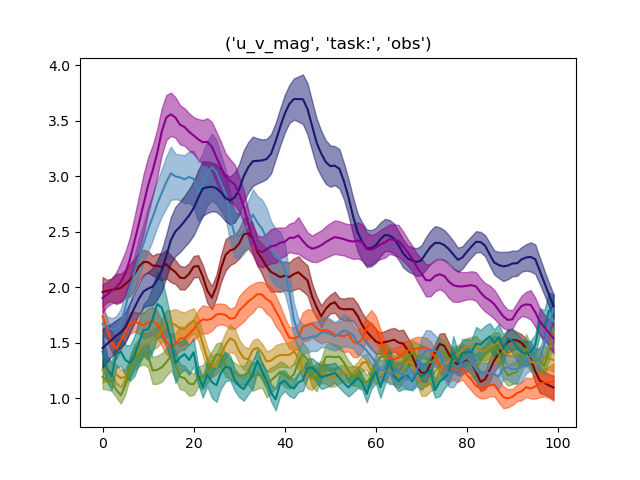

<IPython.core.display.Javascript object>


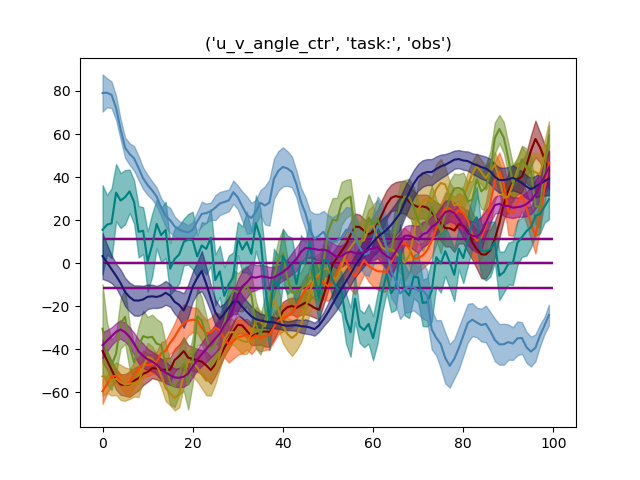

In [257]:
#ALL TARGETS TOGETHER, task separate
ctrl_list = ['p_mag', 'p_angle_ctr', 'v_mag', 'v_angle_ctr', 'u_v_mag', 'u_v_angle_ctr'] #'u_p_mag', 'u_p_angle',
task = 0
# target = 0
plt_len=100

save_bool = False
plt_prefix = 'psth'
plt_ext = ['.png', '.eps']

for task in [0,1]:
    for d in ctrl_list: 
        plt.figure()
        for target in range(num_targets):

            t = psth_dic[task,target,'mean']['time']
            y_mean = psth_dic[task,target,'mean'].loc[d]
            y_sem = psth_dic[task,target,'sem'].loc[d]            
            
            if 'angle_ctr' in d:
#                 y = y*180/np.pi
                y_mean = y_mean*180/np.pi
                y_sem = y_sem*180/np.pi 
                plt.hlines(0,0,plt_len,color=target_color[target])
                plt.hlines(-theta_max*180/np.pi,0,plt_len,color=target_color[target])
                plt.hlines(theta_max*180/np.pi,0,plt_len,color=target_color[target])
            elif 'angle_' in d:
#                 y = y*180/np.pi
                y_mean = y_mean*180/np.pi
                y_sem = y_sem*180/np.pi 
                plt.hlines(target_angle[target]*180/np.pi,0,plt_len,color=target_color[target])
            elif d == 'p_mag':
                plt.hlines(target_dist[target],0,plt_len,color=target_color[target])
                plt.hlines(target_dist[target]-target_r,0,plt_len, linestyles='--', color=target_color[target])
                
            plt.plot(y_mean, color=target_color[target])
            plt.fill_between(range(len(y_mean)), y_mean-y_sem,y_mean+y_sem,alpha=0.5,color=target_color[target])
        plt.title((d, 'task:', idx2task[task]))
        
        if save_bool: 
            plt_name = plt_prefix + '_' + idx2task[task] + '_' + d
            for ext in plt_ext:
                plt.savefig(os.path.join(save_dir, plt_name+ext))
        

### Average over targets and compare task: 

In [292]:
# Average mag, abs angle
ctrl_psth = {}
d_list = ['p_mag', 'p_angle_ctr', 'v_mag', 'v_angle_ctr', 'u_v_mag', 'u_v_angle_ctr']
num_orient_samples = 50
for task in range(num_tasks):
    for d in d_list:
        d_mat = np.zeros((num_targets, num_time))
        d_mat = np.ma.array(d_mat)
        for target in range(num_targets):
            mean = psth_dic[task,target,'mean'].loc[d]
            #ctrl_psth[task,target,d,'mean']
            if 'angle' in d: 
                if np.sum(mean[:num_orient_samples]) > 0:
                    mean = -mean
                #want the absolute angle                
            d_mat[target,:] = mean
        #PSTH:         
#         mean = d_mat.mean(axis=0)
#         N = np.logical_not(np.isnan(d_mat)).sum(axis=0)
#         var = data.var(axis=1)
#         sem = (var/N)**(0.5)        
        ctrl_psth[task,d,'mat'] = d_mat
        ctrl_psth[task,d,'mean'] = d_mat.mean(axis=0)
        ctrl_psth[task,d,'var'] = d_mat.var(axis=0)
        ctrl_psth[task,d,'sem'] = sio_stat.sem(d_mat, axis=0, nan_policy='omit')

In [293]:
#Exclude a target:
task = 1
for d in d_list: 
    d_mat = ctrl_psth[task,d,'mat'][[0,1,2,3,5,6,7],:]
    ctrl_psth[task,d,'mean'] = d_mat.mean(axis=0)
    ctrl_psth[task,d,'var'] = d_mat.var(axis=0)
    ctrl_psth[task,d,'sem'] = sio_stat.sem(d_mat, axis=0, nan_policy='omit')    

In [177]:
d_mat.shape

(8L, 100L)

<IPython.core.display.Javascript object>


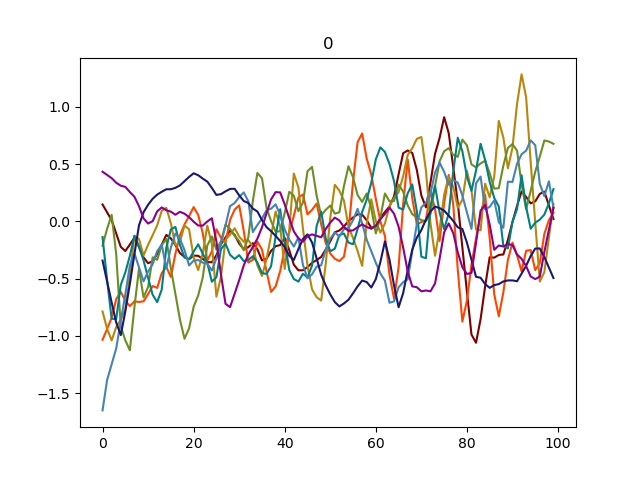

<IPython.core.display.Javascript object>


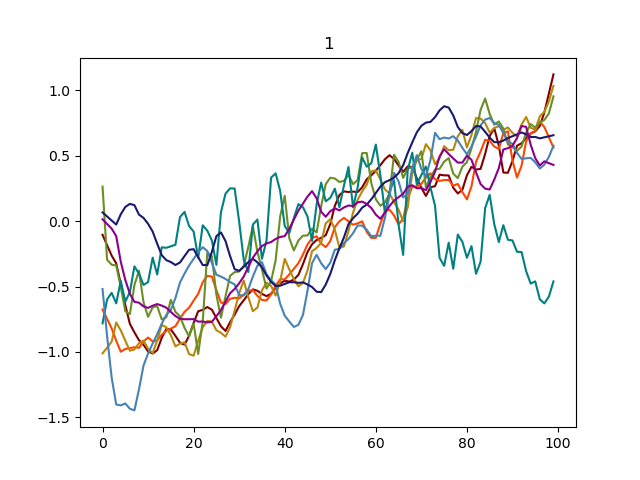

In [294]:
d_list = ['u_v_angle_ctr']
for task in range(num_tasks):
    plt.figure()
    for d in d_list:
        y_mat = ctrl_psth[task,d,'mat']
        for target in range(num_targets):
            plt.plot(y_mat[target,:], color=target_color[target])
    plt.title(task)

<IPython.core.display.Javascript object>


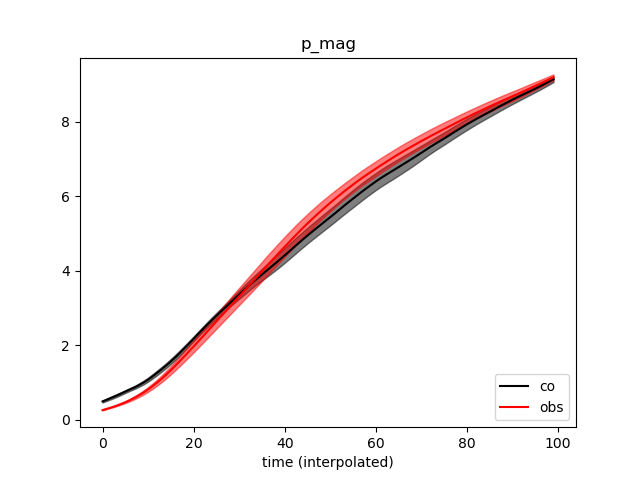

<IPython.core.display.Javascript object>


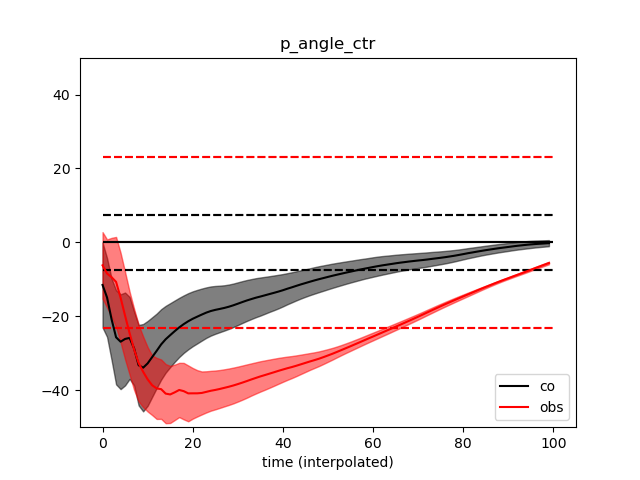

<IPython.core.display.Javascript object>


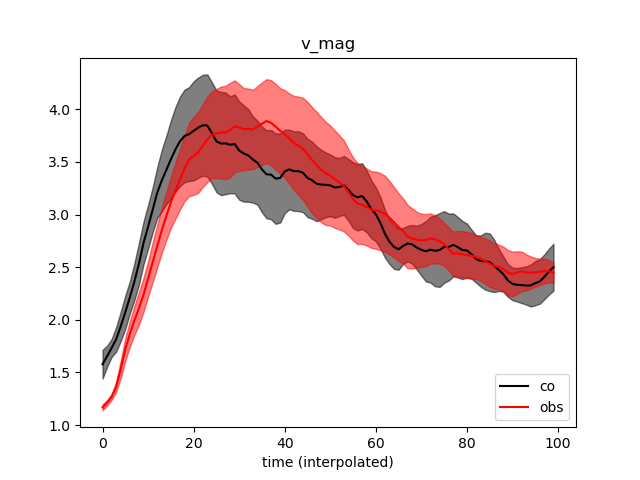

<IPython.core.display.Javascript object>


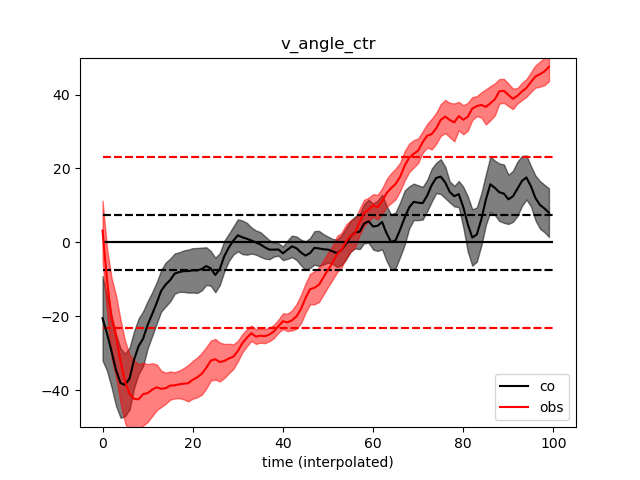

<IPython.core.display.Javascript object>


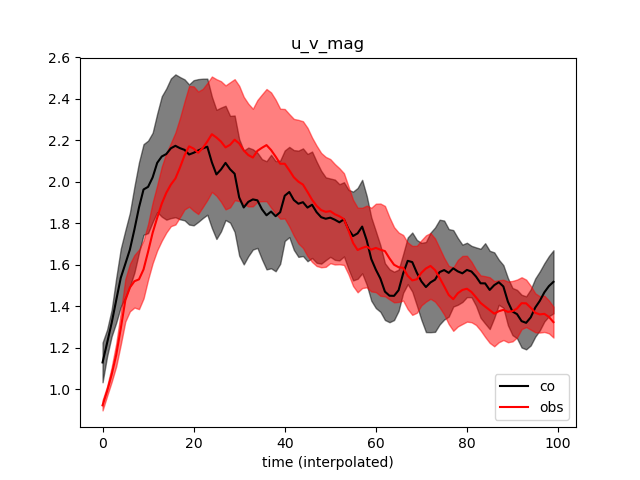

<IPython.core.display.Javascript object>


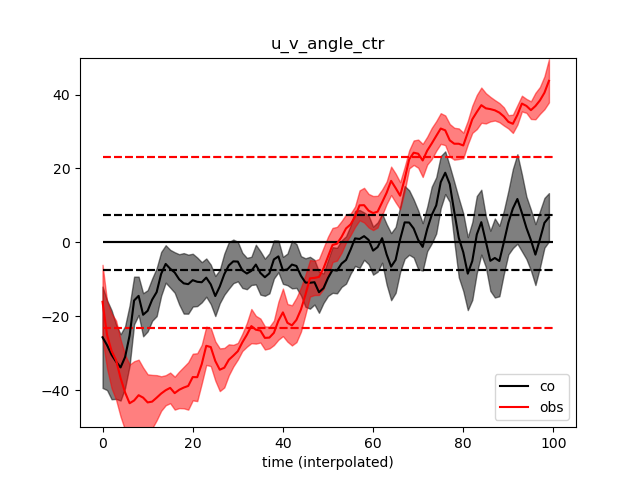

In [312]:
save_bool = False
plt_prefix = 'task_psth'
plt_ext = ['.png']

d_list = ['p_mag', 'p_angle_ctr', 'v_mag', 'v_angle_ctr', 'u_v_mag', 'u_v_angle_ctr']
plot_len = 100
for d in d_list:
    plt.figure()
    for task in range(num_tasks):
        y_mean = ctrl_psth[task,d,'mean'][:plot_len]
        y_sem = ctrl_psth[task,d,'sem'][:plot_len]
        if 'angle' in d:
            y = y*180/np.pi
            y_mean = y_mean*180/np.pi
            y_sem = y_sem*180/np.pi 
            plt.hlines(0,0,plot_len,color='k')
            plt.hlines(theta_max*180/np.pi,0,plot_len,color='k',linestyles='dashed')
            plt.hlines(-theta_max*180/np.pi,0,plot_len,color='k',linestyles='dashed')
            
            plt.hlines(obs_theta*180/np.pi,0,plot_len,color='r',linestyles='dashed')
            plt.hlines(-obs_theta*180/np.pi,0,plot_len,color='r',linestyles='dashed')            
            
            plt.legend()
        plt.plot(y_mean, color=task_color[task],label=idx2task[task])
        plt.fill_between(range(len(y_mean)), y_mean-y_sem,y_mean+y_sem,alpha=0.5,color=task_color[task])
    plt.xlabel('time (interpolated)')
    plt.title(d)
    plt.legend(loc = 'lower right')
    if 'angle' in d:
        plt.ylim(-50,50)
#         plt.axis('square')
    
        
    if save_bool: 
        plt_name = plt_prefix + '_' + d
        for ext in plt_ext:
            plt.savefig(os.path.join(save_dir, plt_name+ext))

In [318]:
trial_bound

array([[  0,  27],
       [ 28,  55],
       [ 56,  89],
       [ 90, 119],
       [120, 154],
       [155, 189],
       [190, 229],
       [230, 264],
       [265, 291],
       [292, 326],
       [327, 378],
       [379, 409],
       [410, 440],
       [441, 471],
       [472, 499],
       [500, 529],
       [530, 556],
       [557, 584],
       [585, 613],
       [614, 641],
       [642, 689],
       [690, 734],
       [735, 765],
       [766, 793],
       [794, 832],
       [833, 857],
       [858, 888]], dtype=int64)

<IPython.core.display.Javascript object>


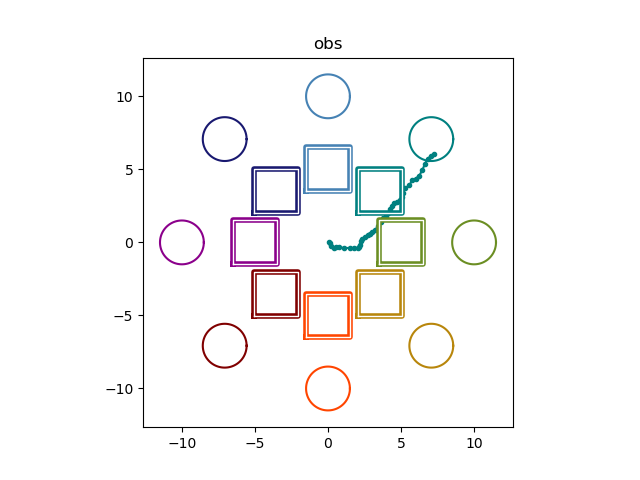

In [334]:
#Plot a specific trajectory: 
#PLOT INDIVIDUAL TRIALS: 

target_list = [4]
trial_list = [25]#[25]

plt.figure()
for task_str in ['obs']:#task_list:
    task = task2idx[task_str]
    for target in target_list: #range(num_targets):
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where((df['trial_start']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_stop = np.where((df['trial_stop']==1) & (df['target']==target) & (df['task']==task))[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        num_trials = trial_bound.shape[0]
        #------------------------------------------------------------------------------------
        plot_trial_bound = trial_bound[trial_list,:]
        for bnd in plot_trial_bound: #trial_bound[0:1,:]:
            x = df['kin_px'][bnd[0]:bnd[1]+1]
            y = df['kin_py'][bnd[0]:bnd[1]+1]
#             print(x)
            color = target_color[target]
            plt.plot(x,y,'.-',color=color)

    if plot_obs_small:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
    if plot_obs_big:
        bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
    if plot_target: 
        bmi_util.plot_targets(target_pos, target_color, target_r_eff[task]*np.ones(num_targets))  
    
    plt.axis('square')
    plt.title(task_str)
#     plt.xlim(plot['xlim'])
#     plt.ylim(plot['ylim'])
    plt.show()        
        
        


In [335]:
df.loc[bnd[0]:bnd[1],'p_angle_ctr'].mean()*180/np.pi

-31.017173383136694

In [331]:
df[bnd[0]:bnd[1]]

n_0  n_1  n_2  n_3  n_4  n_5  n_6  n_7  n_8  n_9  ...  u_p_angle  \
12613  2.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...  -3.103022   
12614  1.0  0.0  0.0  1.0  2.0  1.0  0.0  0.0  0.0  0.0  ...   2.802263   
12615  5.0  0.0  0.0  0.0  2.0  3.0  2.0  0.0  0.0  0.0  ...  -2.254640   
12616  0.0  1.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  0.0  ...   2.722285   
12617  1.0  0.0  0.0  0.0  1.0  4.0  0.0  0.0  0.0  0.0  ...   2.036795   
12618  0.0  1.0  0.0  0.0  1.0  3.0  2.0  0.0  0.0  0.0  ...  -0.588083   
12619  1.0  1.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  ...   2.216581   
12620  0.0  0.0  0.0  0.0  1.0  3.0  2.0  0.0  0.0  0.0  ...  -1.009933   
12621  1.0  1.0  0.0  0.0  2.0  3.0  1.0  0.0  0.0  0.0  ...  -1.287117   
12622  2.0  0.0  0.0  0.0  2.0  1.0  1.0  0.0  0.0  0.0  ...  -2.834297   
12623  1.0  1.0  0.0  0.0  0.0  4.0  2.0  1.0  0.0  0.0  ...   1.769555   
12624  1.0  0.0  0.0  0.0  0.0  2.0  1.0  0.0  0.0  0.0  ...   1.693760   
12625  0.0  1.0  0.0  0.0  1.0  3.0  1.0  0.0  0.0  0.0  ...   0.960404   
12626  0.0  2.0  0.0  0.0  2.0  2.0  4.0  0.0  0.0  0.0  ...   0.235536   
12627  0.0  0.0  0.0  0.0  0.0  3.0  1.0  2.0  0.0  0.0  ...   0.152591   
12628  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   1.254733   
12629  0.0  0.0  0.0  0.0  1.0  2.0  0.0  0.0  0.0  0.0  ...   1.269742   
12630  0.0  0.0  1.0  0.0  0.0  3.0  4.0  0.0  0.0  0.0  ...  -0.362484   
12631  1.0  0.0  0.0  0.0  1.0  2.0  2.0  0.0  0.0  0.0  ...   0.196548   
12632  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  ...   0.123467   
12633  1.0  1.0  0.0  0.0  0.0  1.0  2.0  0.0  0.0  0.0  ...   0.886564   
12634  0.0  0.0  0.0  0.0  0.0  2.0  3.0  0.0  0.0  0.0  ...   0.758326   
12635  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  ...   0.616788   
12636  0.0  2.0  0.0  0.0  0.0  3.0  3.0  0.0  0.0  0.0  ...   0.104570   
12637  1.0  1.0  0.0  0.0  1.0  2.0  1.0  1.0  0.0  0.0  ...  -2.021840   
12638  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  -0.580432   
12639  2.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  ...   0.776258   
12640  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.209728   
12641  4.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   0.869336   
12642  0.0  1.0  0.0  0.0  0.0  3.0  1.0  1.0  0.0  0.0  ...  -0.330157   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...        ...   
12646  1.0  0.0  0.0  0.0  0.0  2.0  1.0  0.0  0.0  0.0  ...   1.028178   
12647  2.0  1.0  0.0  0.0  1.0  2.0  2.0  0.0  0.0  0.0  ...   0.593804   
12648  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  -0.149827   
12649  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  ...   1.164097   
12650  1.0  2.0  0.0  0.0  1.0  5.0  4.0  0.0  0.0  0.0  ...  -2.023357   
12651  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   0.635061   
12652  0.0  1.0  0.0  0.0  0.0  3.0  1.0  0.0  0.0  0.0  ...   0.368287   
12653  0.0  0.0  0.0  0.0  0.0  4.0  1.0  0.0  0.0  0.0  ...   0.287959   
12654  3.0  2.0  0.0  0.0  1.0  1.0  4.0  0.0  0.0  0.0  ...   1.389323   
12655  0.0  1.0  0.0  0.0  1.0  3.0  1.0  1.0  0.0  1.0  ...  -1.157445   
12656  0.0  0.0  0.0  0.0  1.0  2.0  2.0  0.0  0.0  0.0  ...   0.867039   
12657  1.0  1.0  0.0  0.0  0.0  3.0  1.0  2.0  0.0  0.0  ...   0.636421   
12658  0.0  2.0  1.0  0.0  1.0  2.0  0.0  0.0  0.0  0.0  ...   1.701785   
12659  2.0  0.0  0.0  0.0  0.0  1.0  2.0  0.0  0.0  0.0  ...   1.567622   
12660  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  ...   1.392100   
12661  0.0  0.0  0.0  1.0  0.0  3.0  2.0  0.0  0.0  0.0  ...   1.088669   
12662  2.0  0.0  0.0  0.0  1.0  4.0  0.0  0.0  0.0  0.0  ...   0.841935   
12663  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  -2.344139   
12664  1.0  0.0  0.0  0.0  2.0  1.0  1.0  1.0  0.0  0.0  ...   1.790690   
12665  0.0  1.0  1.0  0.0  1.0  1.0  4.0  0.0  0.0  0.0  ...   1.147356   
12666  0.0  1.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  0.0  ...   1.288370   
12667  2.0  0.0  0.0  0.0  1.0  